In [2]:
# !cp drive/MyDrive/python檔/aicup/run/dataset.py .
# !cp drive/MyDrive/python檔/aicup/run 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import sys
sys.path.insert(0,"/content/drive/My Drive/python檔/aicup/run")

In [5]:
pip install transformers==3

     |████████████████████████████████| 757kB 23.0MB/s 
     |████████████████████████████████| 1.1MB 50.3MB/s 
     |████████████████████████████████| 3.0MB 47.5MB/s 
     |████████████████████████████████| 890kB 53.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=62efe2686575d7158c4974ead1abc61b27873f12efc518c61ad636099827e52c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [6]:
pip install pytorch-crf

In [7]:
pip install pytorch_warmup

In [8]:
from dataset import bert_stc_dataset
# from model2 import model_crf
from train import train
# from txt_preprocess2 import preprocess2
import re

from transformers import BertModel, BertTokenizer, get_cosine_schedule_with_warmup
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchcrf import CRF
import pytorch_warmup as warmup
from torch.autograd import Variable


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt

In [9]:
file_path = '/content/drive/My Drive/python檔/aicup/run/data/train_input.data'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('{} is being used'.format(device))

cuda is being used


# preprocess

In [10]:
class preprocess2():
	def __init__(self, data):
		self.data = data
		self.article_id_list = list()
		self.data_list= list()
		data_list_tmp = list()
		idx = 0

		for row in data:
			data_tuple = tuple()
			if row == '\n':
				self.article_id_list.append(idx)
				idx+=1
				# data_list_tmp.append(('[SEP]','[SEP]'))
				self.data_list.append(data_list_tmp)
				# data_list_tmp = [('[CLS]','[CLS]')]
				data_list_tmp = []

			else:
				row = row.strip('\n').split(' ')

				if row[0] in ['。', '？','！','～','：','，']:
					self.article_id_list.append(idx)
					self.data_list.append(data_list_tmp)
					data_list_tmp= []

				elif row[0] not in ['摁','嗯','啦','喔','欸','啊','齁','嘿','…','...']:
					data_tuple = (row[0], row[1])
					data_list_tmp.append(data_tuple)
				#data_list_tmp 儲存暫時的data_tuple(token,label)
		if len(data_list_tmp) != 0:
			self.data_list.append(data_list_tmp)

		# print(len(self.data_list), len(self.article_id_list))
		# print(self.data_list[0])
		# traindata_list, testdata_list, traindata_article_id_list, testdata_article_id_list=train_test_split(self.data_list,self.article_id_list,test_size= 0.33)
		# print('ex1 ',self.data_list[2])

	def get_stc_label(self):
		all_stcs = list()
		all_labels = list()

		for article_txt_tuple, article_id in zip(self.data_list, self.article_id_list):

			txt_len = len(article_txt_tuple) #(文章數，每個文章對應的總字數) (word, label)
			stc = str() #存字數= max_stc_len的字串
			# labels = ['[CLS]'] # 存該字串對應的label # pytorch crf不需要
			labels = []

			for idx, (word, label) in enumerate(article_txt_tuple):

				stc += word
				labels.append(label)

			# labels.append('[SEP]') # pytorch crf 不需要sep
			
			all_stcs.append(stc)
			all_labels.append(labels)

		all_stcs_clean = []
		all_labels_clean = []

		for stc, label in zip(all_stcs,all_labels):
			
			stc_clean = re.sub(r'(醫師)|(個管師)|(民眾)|(家屬)|(護理師)', '', stc)
			# print(stc, stc_clean, label)
			if (len(stc_clean)>=2) & (len(set(label)) >= 2):	
				# print(stc_clean, stc)
				all_stcs_clean.append(stc)

				# len_diff = len(stc) - len(stc_clean)
				
				# if len_diff >= 3:

				# 	del label[1:1+len_diff]
				# if len(set(label)) >= 2:
				# 	print(stc,stc_clean, label)
				all_labels_clean.append(label)

		# 這一步就先把label 做 0 padding

		max_length = len(max(all_stcs_clean, key=len)) 
		pad_labels = []

		for i in range(len(all_labels_clean)):
			temp_label = ['[PAD]']*max_length
			temp_label[:len(all_labels_clean[i])] = all_labels_clean[i]
			pad_labels.append(temp_label)

		print('sentences總數: {}'.format(len(all_stcs_clean)))
		print('labels總數: {}'.format(len(all_labels_clean)))
		# print(all_stcs[0])
		# print(all_labels[0])
		return all_stcs_clean, pad_labels

	def tag2id(self, stcs_label):

		all_label = list()
		for stc_label in stcs_label:
			for label in stc_label:
				all_label.append(label)

		labels_set = sorted(set(all_label))
		tag2id_dict = {'[PAD]':0} #固定將PAD id設為0

		labels_set.remove('[PAD]')

		for idx, label in enumerate(labels_set):
			tag2id_dict[label] = idx+1

		# tag2id_dict['[CLS]'] = len(tag2id_dict) 
		# tag2id_dict['[SEP]'] = len(tag2id_dict)

		return tag2id_dict

	def label_to_ids(self, tag_to_id, raw_labels):

		label2id = []
		for stc_labels in raw_labels:
			stc_label_ids = [tag_to_id[label] for label in stc_labels]
			label2id.append(stc_label_ids)
		return label2id

	def get_stcs_label2ids(self):

		stcs, labels = self.get_stc_label()
		tag2id = self.tag2id(stcs_label= labels)
		labels_ids= self.label_to_ids(tag_to_id= tag2id, raw_labels= labels)

		return stcs, labels_ids


# model

In [11]:
class model_crf(nn.Module):
	def __init__(self, n_tags, hidden_dim=768, batchsize= 64):
		super(model_crf, self).__init__()
		self.n_tags = n_tags
		self.lstm =  nn.LSTM(bidirectional=True, num_layers=2, input_size=768, hidden_size=hidden_dim//2, dropout= 0.1, batch_first=True)		
		self.hidden_dim = hidden_dim
		self.fc = nn.Linear(hidden_dim, self.n_tags)
		self.bert = BertModel.from_pretrained('bert-base-chinese')
		# self.bert.eval()  # 知用来取bert embedding
		self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
		self.CRF = CRF(n_tags, batch_first= True)
		self.hidden = self.init_hidden(batchsize)

	def init_hidden(self, batchsize):
		return Variable(torch.randn(2*2, batchsize, self.hidden_dim // 2)).to(self.device), Variable(torch.randn(2*2, batchsize, self.hidden_dim // 2)).to(self.device)

	def neg_log_likelihood(self, input_ids, attention_mask, tags):

		# feats : [batchsize, seq_len, n_tags]
		# tags : [batchsize, n_tags]
		encoded_layer, _  = self.bert(input_ids.long(), attention_mask)
		enc, _ = self.lstm(encoded_layer, self.hidden)
		lstm_feats = self.fc(enc)
		# lstm_feats[:,:,-1] = lstm_feats[:,:,-1]*0.001

		loss = -self.CRF(lstm_feats, tags, attention_mask.bool(), reduction= 'mean')

		return loss 

	def forward(self, input_ids, attention_mask, tags):

		encoded_layer, _  = self.bert(input_ids.long(), attention_mask)
		enc, _ = self.lstm(encoded_layer)
		lstm_feats = self.fc(enc)
		lstm_feats[:,:,1:-1] = lstm_feats[:,:,1:-1]*10
		loss = -self.CRF(lstm_feats, tags, attention_mask.bool(), reduction= 'token_mean')
		pred_seqs = self.CRF.decode(emissions= lstm_feats, mask= attention_mask.bool())
		return loss, pred_seqs

# 參數設定

sentences總數: 1943
labels總數: 1943
sentences總數: 1943
labels總數: 1943
{'[PAD]': 0, 'B-ID': 1, 'B-clinical_event': 2, 'B-contact': 3, 'B-education': 4, 'B-family': 5, 'B-location': 6, 'B-med_exam': 7, 'B-money': 8, 'B-name': 9, 'B-organization': 10, 'B-profession': 11, 'B-time': 12, 'I-ID': 13, 'I-clinical_event': 14, 'I-contact': 15, 'I-education': 16, 'I-family': 17, 'I-location': 18, 'I-med_exam': 19, 'I-money': 20, 'I-name': 21, 'I-organization': 22, 'I-profession': 23, 'I-time': 24, 'O': 25}
tags數: 26
0|0.7639760192513666
1|0.00011127957602481535
2|6.954973501550959e-05
3|0.00026428899305893646
4|4.1729841009305755e-05
5|0.00034774867507754794
6|0.0022395014674994086
7|0.00304627839367932
8|0.0010849758662419497
9|0.002267321361505613
10|1.3909947003101918e-05
11|0.00018082931104032492
12|0.019835584426423334
13|0.00020864920504652876
14|0.00020864920504652876
15|0.0010988858132450516
16|4.1729841009305755e-05
17|0.0003894785160868537
18|0.00333838728074446
19|0.00536923954319734
20|0.

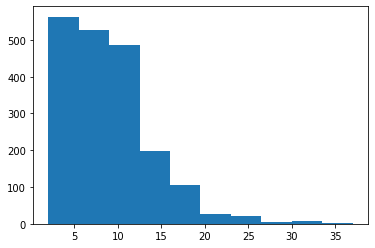

max_stc_length 37
training stcs 總數: 1554
num_interation 49


In [15]:
# ---------------前處理---------------
with open(file_path, 'r', encoding='utf-8') as f:
	data=f.readlines()#.encode('utf-8').decode('utf-8-sig')

preprocessor = preprocess2(data)

stcs, original_labels= preprocessor.get_stc_label()
stcs, labels = preprocessor.get_stcs_label2ids()
tag2id_dict = preprocessor.tag2id(original_labels)
n_tags = len(tag2id_dict)
print(tag2id_dict)
print('tags數: {}'.format(n_tags))

gt_tags = [tag for label in labels for tag in label]

for tag in set(gt_tags):
  print('{}|{}'.format(tag, gt_tags.count(tag)/len(gt_tags)))
# plt.hist(gt_tags)
plt.hist([len(stc) for stc in stcs])
plt.show()


tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
# max_length = max([len(txt) for txt in stcs]) # [CLS] + [SEP]
max_length = len(max(stcs, key=len)) 
print('max_stc_length', max_length)

# ---------------模型---------------
batchsize= 32
model = model_crf(n_tags= n_tags, hidden_dim= 256, batchsize= batchsize).to(device)
# print(summary(model,[(128, 300), (128,300)]))

train_x, test_x, train_y, test_y = train_test_split(stcs, labels, test_size= 0.2, shuffle= False, random_state= 42)

train_dataset = bert_stc_dataset(stcs= train_x, labels= train_y, tokenizer= tokenizer, max_length= max_length)
test_dataset = bert_stc_dataset(stcs= test_x, labels= test_y, tokenizer= tokenizer, max_length= max_length)

print('training stcs 總數: {}'.format(len(train_dataset)))
train_dataloader = DataLoader(train_dataset, batch_size= batchsize, shuffle= True)
test_dataloader = DataLoader(test_dataset, batch_size= batchsize, shuffle= False)

num_epochs = 40
num_iteration = len(train_dataloader)
print('num_interation',num_iteration)
total_iter = num_iteration * num_epochs
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=3000, num_training_steps=total_iter)
# warmup_scheduler = warmup.ExponentialWarmup(optimizer, warmup_period=150)

# ---------------訓練---------------
# train_model = train(model= model, optimizer= optimizer, train_loader= train_dataloader, test_loader= 0, num_epochs= 5, device= device)

# test function

In [16]:
def test(model, test_dataloader, device):

  preds_epoch = []
  gts_epoch = []
  epoch_loss = 0
  iteration = 0

  model.eval()

  for idx, batch_dict in enumerate(test_dataloader):

    # print('idx: ',idx+1)
    input_ids = batch_dict['input_ids'].to(device)
    attention_mask = batch_dict['attention_mask'].to(device)
    labels = batch_dict['labels'].to(device)

    with torch.no_grad():
      loss, pred_labels = model(input_ids, attention_mask.bool(), labels)

    # mask gt labels 
    labels = batch_dict['labels'].numpy()
    masks = batch_dict['attention_mask'].numpy()

    labels_nopad = []
    for label , seq_mask in zip(labels, masks):

      seq = [tag for tag, mask in zip(label, seq_mask) if mask == 1]
      labels_nopad.append(seq)

    # one dim array 
    preds= [tag for seq in pred_labels for tag in seq]
    gts= [tag for seq in labels_nopad for tag in seq]

    preds_epoch += preds
    gts_epoch += gts

    epoch_loss += loss.item()
    iteration += 1

  f1_macro = f1_score(y_true= gts_epoch, y_pred= preds_epoch, average= 'macro')
  f1_micro = f1_score(y_true= gts_epoch, y_pred= preds_epoch, average= 'micro')
  avg_loss = epoch_loss / iteration
  
  print('test_f1(macro, micro) ({:.2f},{:.2f}) | test_avg_loss {:.2f}'.format(f1_macro, f1_micro, avg_loss))

  return f1_macro, f1_micro, avg_loss

# 訓練

In [18]:
train_loss = {}
test_loss = {}
train_f1 = {}
test_f1 = {}

for epoch in range(num_epochs):

  preds_epoch = []
  gts_epoch = []
  epoch_loss = 0
  iteration = 0

  model.train()

  for idx, batch_dict in enumerate(train_dataloader):

    # print('idx: ',idx+1)
    input_ids = batch_dict['input_ids'].to(device)
    attention_mask = batch_dict['attention_mask'].to(device)
    labels = batch_dict['labels'].to(device)

    loss, pred_labels = model(input_ids, attention_mask.bool(), labels)

    # loss = model.neg_log_likelihood(input_ids, attention_mask, labels)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

    # if (idx+1) % 5 == 0:
    optimizer.step()
    scheduler.step()
    # warmup_scheduler.dampen()
    model.zero_grad()

    # mask gt labels 
    labels = batch_dict['labels'].numpy()
    masks = batch_dict['attention_mask'].numpy()
    # masked_list = (labels*mask).numpy()

    labels_nopad = []
    for label , seq_mask in zip(labels, masks):

      seq = [tag for tag, mask in zip(label, seq_mask) if mask == 1]
      labels_nopad.append(seq)

    # one dim array 
    preds= [tag for seq in pred_labels for tag in seq]
    gts= [tag for seq in labels_nopad for tag in seq]

    preds_epoch += preds
    gts_epoch += gts

    epoch_loss += loss.item()
    iteration += 1

    # print('pred_labels', pred_labels)
    # # print('preds:', preds)
    # print('gts:',gts)
    # print(round(f1_score(y_true= gts, y_pred= preds, average= 'macro'),2))
    # # print(f1_score(y_true= gts, y_pred= preds, average= 'micro'))
    # print(round(loss.item(),2))

    # print('idx:{} loss:{}'.format(idx, loss))

  f1 = f1_score(y_true= gts_epoch, y_pred= preds_epoch, average= 'macro')
  f1_micro = f1_score(y_true= gts_epoch, y_pred= preds_epoch, average= 'micro')
  avg_loss = epoch_loss / iteration
  

  print('epoch {}/{} | train_f1(macro, micro) ({:.2f},{:.2f}) | train_epoch_avg_loss {:.2f}'.format(epoch+1, num_epochs, f1, f1_micro, avg_loss))

  test_f1_macro, test_f1_micro, test_avg_loss = test(model= model, test_dataloader= test_dataloader, device= device)

  train_loss[epoch+1] = avg_loss
  test_loss[epoch+1] = test_avg_loss
  train_f1[epoch+1] = f1
  test_f1[epoch+1] = test_f1_macro


epoch 1/40 | train_f1(macro, micro) (0.02,0.17) | train_epoch_avg_loss 2.62
test_f1(macro, micro) (0.02,0.20) | test_avg_loss 2.17
epoch 2/40 | train_f1(macro, micro) (0.04,0.47) | train_epoch_avg_loss 1.92
test_f1(macro, micro) (0.07,0.67) | test_avg_loss 1.53
epoch 3/40 | train_f1(macro, micro) (0.06,0.65) | train_epoch_avg_loss 1.50
test_f1(macro, micro) (0.07,0.68) | test_avg_loss 1.28
epoch 4/40 | train_f1(macro, micro) (0.07,0.67) | train_epoch_avg_loss 1.27
test_f1(macro, micro) (0.10,0.72) | test_avg_loss 1.05
epoch 5/40 | train_f1(macro, micro) (0.12,0.74) | train_epoch_avg_loss 1.02
test_f1(macro, micro) (0.16,0.81) | test_avg_loss 0.76
epoch 6/40 | train_f1(macro, micro) (0.17,0.80) | train_epoch_avg_loss 0.80
test_f1(macro, micro) (0.22,0.87) | test_avg_loss 0.58
epoch 7/40 | train_f1(macro, micro) (0.21,0.85) | train_epoch_avg_loss 0.64
test_f1(macro, micro) (0.28,0.90) | test_avg_loss 0.47
epoch 8/40 | train_f1(macro, micro) (0.25,0.87) | train_epoch_avg_loss 0.53
test_f1

In [ ]:
# torch.save(model, 'ner_model_batch32_wup3000_lstmhd256_lre-4_40epoch.pt')

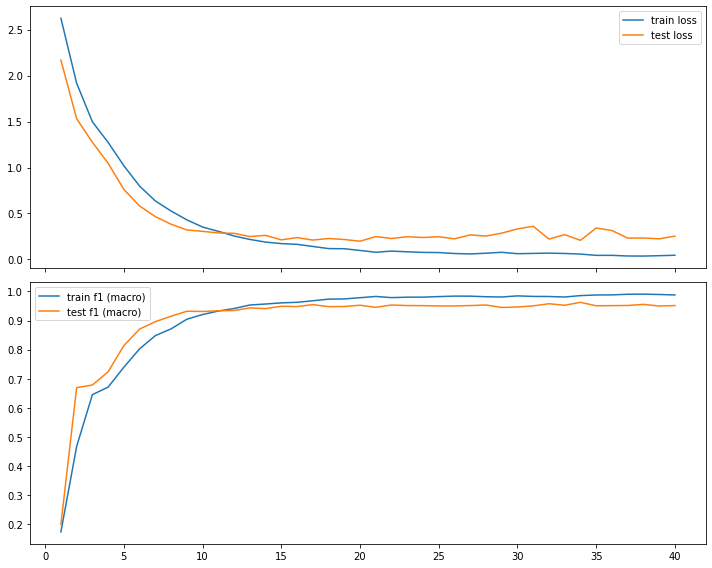

In [36]:
fig, (ax1, ax2) = plt.subplots(nrows= 2, ncols= 1, figsize= (10,8), sharex= True)
ax1.plot([*range(1, num_epochs+1)], list(train_loss.values()), label= 'train loss')
ax1.plot([*range(1, num_epochs+1)], list(test_loss.values()), label= 'test loss')
ax1.legend()

ax2.plot([*range(1, num_epochs+1)], list(train_f1.values()), label= 'train f1 (macro)')
ax2.plot([*range(1, num_epochs+1)], list(test_f1.values()), label= 'test f1 (macro)')
ax2.legend()

plt.tight_layout()
plt.show()